# Hourly Bike Rentals
## Evaluation Question: How are hourly bike rentals affected by weather and seasonal factors?
### Variable Key
* `instant`: record index
* `dteday` : date
* `season` : season (`1`:winter, `2`:spring, `3`:summer, `4`:fall)
* `yr` : year (`0`: 2011, `1`:2012)
* `mnth` : month ( 1 to 12)
* `hr` : hour (0 to 23)
* `holiday` : whether day is holiday (`1`) or not (`0`)
* `weekday` : day of the week (`0`: Sunday through `6`: Saturday)
* `workingday` : if day is neither weekend nor holiday is `1`, otherwise is `0`.
* `weathersit` :
    * `1`: Clear, Few clouds, Partly cloudy, Partly cloudy
    * `2`: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * `3`: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * `4`: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* `temp` : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* `atemp`: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* `hum`: Normalized humidity. The values are divided to 100 (max)
* `windspeed`: Normalized wind speed. The values are divided to 67 (max)
* `casual`: count of casual users
* `registered`: count of registered users
* `cnt`: count of total rental bikes including both casual and registered

## Import Libraries

In [33]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Load Data

In [3]:
bikes = pd.read_csv('hour.csv')
bikes

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [4]:
# Make a copy of the data, just in case
bikes1 = bikes

## Data Wrangling

### Check Variable Types (Transform object types as needed)

In [5]:
# Check data types of the entire dataframe
bikes1.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [8]:
# Transform all categorical variables from `int64` to appropriate types for our analyses
bikes1.dteday = bikes1.dteday.astype('datetime64')
bikes1.season = bikes1.season.astype('category')
bikes1.yr = bikes1.yr.astype('category')
bikes1.mnth = bikes1.mnth.astype('category')
bikes1.hr = bikes1.hr.astype('category')
bikes1.holiday = bikes1.holiday.astype('bool')
bikes1.weekday = bikes1.weekday.astype('category')
bikes1.workingday = bikes1.workingday.astype('bool')
bikes1.weathersit = bikes1.weathersit.astype('category')

In [9]:
# Check dtypes to be sure transformations occurred as desired
bikes1.dtypes

instant                int64
dteday        datetime64[ns]
season              category
yr                  category
mnth                category
hr                  category
holiday                 bool
weekday             category
workingday              bool
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [10]:
bikes1

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,False,1,True,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,False,1,True,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,False,1,True,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,False,1,True,1,0.26,0.2727,0.56,0.1343,13,48,61


### Descriptive Statistics

In [11]:
bikes1.describe()

,instant,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


The descriptive statistics above are difficult to make meaning out of for anything except the last 3 columns (the potential dependent variables). Because the `temp`, `atemp`, `hum`, and `windspeed` are already normalized, there is not much physical meaning we can make out of those numbers at this time.

We can see that the average number of registered users is much higher than the average number of casual users. 

### Correct for Missing Values
Based on the Count for all numerical values above being exactly the same, I suspect that our data is fairly "full." However, we will run `.dropna()` to be sure that we won't run in to any trouble with later analyses.

In [12]:
bikes1.dropna()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,False,1,True,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,False,1,True,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,False,1,True,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,False,1,True,1,0.26,0.2727,0.56,0.1343,13,48,61


Indeed, after running `.dropna()`, we still have the same number of rows as the initial imported set, so we know that we did not lose any data due to having any missing values.

### Check the Distribution of Variables and Detect Any Outliers

#### Independent Variables
Visualizing counts of the independent variables of season, yr, month, hr, and weekday will not tell us much of anything on their own because we would expect the numbers of observations for those hours to be approximately equal. (We assume that every hour of every day is a "bin" for reporting the numbers of users.)

There is not much point in visualizing the temp, atemp, hum, or windspeed variables either because they have already been reported to us as normalized from 0 to 1. IF there were any outliers, they should have already been accounted for before normalizing the values, so we have no control over whether that step was completed appropriately.

Therefore, the only reasonable visualizations are in relation to the dependent variables.

#### Dependent Variables
As the 3 potential dependent variables are completed related to each other (by `cnt` = `casual` + `registered`), we would expect that a histogram of each varible would show similar trends.

<AxesSubplot:xlabel='cnt', ylabel='Count'>

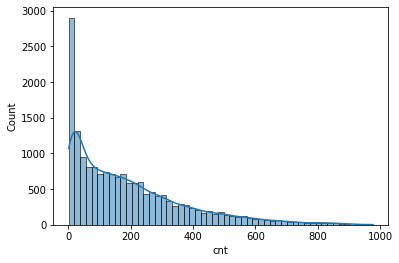

In [11]:
sns.histplot(bikes1["cnt"], kde=True)

<AxesSubplot:xlabel='casual', ylabel='Count'>

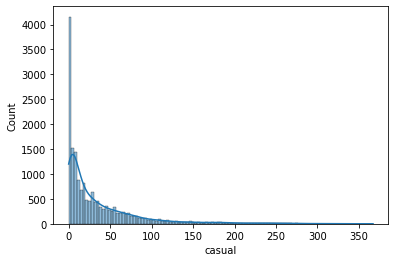

In [12]:
sns.histplot(bikes1["casual"], kde=True)

<AxesSubplot:xlabel='registered', ylabel='Count'>

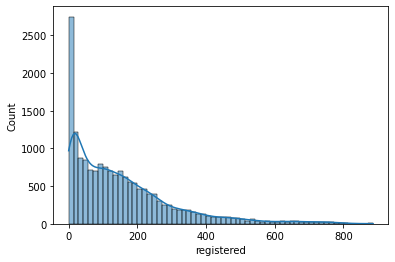

In [13]:
sns.histplot(bikes1["registered"], kde=True)

Indeed, we see that the 3 potential dependent variables show approximately the same distributions.

<AxesSubplot:>

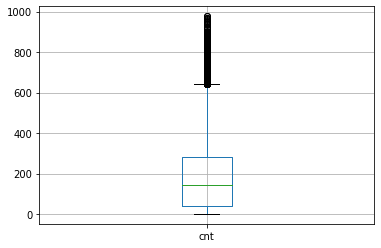

In [13]:
# Create a boxplot for total count of bike rentals
bikes1.boxplot(column='cnt')

This boxplot clearly shows a large number of "outliers" (1.5*IQR) - as shown by the dark wide line above the top whisker. However, we already know that our data are not normally distributed (we expect to have many more low-rental-counts than high rental counts), which heavily skews the descriptive statistics. Therefore, we will not remove "outliers" at this time.

# Regression and MANOVA
We will use step-wise regression and MANOVA to determine which factors are most significant in predicting the number of bike rentals. This process is easiest to complete in R. So we will refer to a companion R notebook available [HERE](https://github.com/aglisson6/ENTITY-Data-Science-Virtual-Academy-Final-Project/blob/main/Abi_Glisson%20-%20Final%20Project%20-%20R.ipynb).

## Dependent Variables
Our analysis in R determined that `cnt` is too closely related to `registered`, so we can use `casual` and `registered` without worrying about `cnt` and that will account for nearly all of the variance in `cnt`. This was to be expected as `cnt` is simply the addition of `casual` and `registered` together.

## Independent Variables
Our analysis in R showed that all possible dependent variables (both continuous and categorical) were strong predictors of the dependent variables. Therefore, we will need to make educated choices about which variables to include and exclude in order to not overfit the model.

# Machine Learning Prediction

## Linear Regression

In [57]:
# Split your variables into x and y

# Select remove `dteday` as dates do not play nicely with machine learning.
x = bikes1[['season', 'yr', 'mnth', 'hr', 'workingday', 'weekday', 'holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

# We will run the model to predict `casual` and `registered` users
y = bikes1[['casual', 'registered']]

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .4, random_state=101)

In [59]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(10427, 12) (10427, 2)
(6952, 12) (6952, 2)


In [60]:
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [61]:
predictions = lm.predict(x_test)

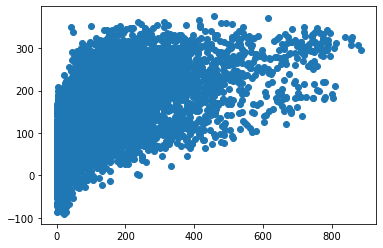

In [62]:
plt.scatter(y_test, predictions)

In [63]:
print("Score:", lm.score(x_test, y_test))

Score: 0.3990655529804673


In [64]:
metrics.mean_absolute_error(y_test, predictions)

56.57793967687116

In [65]:
metrics.mean_squared_error(y_test, predictions)

8292.157991602679

In [66]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

91.06128700827085

### k-Folds Cross Validation of the Linear Regression Model

In [67]:
kfold = KFold(n_splits = 3, shuffle = True, random_state = 1)

In [68]:
print(cross_val_score(lm, x, y, cv = 3))

[0.25906252 0.28968812 0.33158837]


### Conclusion

We can see that the Linear Regression model does not produce particularly robust predictive capabilities. Let's try a Random Forest.

## Random Forest

In [74]:
y_cas = bikes1['casual']
y_reg = bikes1['registered']

x_train, x_test, y_train, y_test = train_test_split(x,y_cas, test_size=0.3, random_state=76)

In [75]:
forest = RandomForestClassifier(n_estimators=10, random_state=76)
forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=76)

In [76]:
forestPredictions = forest.predict(x_test)
print(confusion_matrix(y_test, forestPredictions))
print(classification_report(y_test, forestPredictions))

[[272  82  43 ...   0   0   0]
 [153  75  41 ...   0   0   0]
 [ 87  53  37 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
              precision    recall  f1-score   support

           0       0.41      0.60      0.49       450
           1       0.21      0.23      0.22       325
           2       0.15      0.15      0.15       255
           3       0.15      0.15      0.15       196
           4       0.07      0.06      0.06       178
           5       0.10      0.11      0.11       156
           6       0.06      0.05      0.05       132
           7       0.05      0.05      0.05       114
           8       0.02      0.03      0.02       107
           9       0.08      0.07      0.08       108
          10       0.09      0.07      0.08       105
          11       0.01      0.01      0.01        94
          12       0.02      0.03      0.02        75
          13       0.09      0.09      0.09        

C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and 

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x,y_reg, test_size=0.3, random_state=76)

In [78]:
forest = RandomForestClassifier(n_estimators=10, random_state=76)
forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=76)

In [79]:
forestPredictions = forest.predict(x_test)
print(confusion_matrix(y_test, forestPredictions))
print(classification_report(y_test, forestPredictions))

[[ 0  2  3 ...  0  0  0]
 [ 1 12 13 ...  0  0  0]
 [ 2 14 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.13      0.20      0.15        61
           2       0.08      0.14      0.10        70
           3       0.24      0.27      0.25        94
           4       0.05      0.06      0.05        86
           5       0.07      0.10      0.08        78
           6       0.10      0.12      0.11        75
           7       0.02      0.03      0.02        39
           8       0.09      0.09      0.09        55
           9       0.06      0.06      0.06        51
          10       0.00      0.00      0.00        45
          11       0.11      0.12      0.11        41
          12       0.07      0.09      0.08        22
          13       0.00      0.00      0.00        25
          14       0.05      0.03

C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and 